# Get Data
This notebook contains code that reads the binary data as a 3d matrix (ReadData), stores it into a dataframe (WholeDF), and then performs more calculations that are to be used later (CleanDF). We can read every binary file in the 'RawData' folder and store the respective whole and cleaned dataframes into the folder 'DataFrames'. The dataframes are saved according to their particle dimensions and type. For example, a cleaned dataframe of 2x2 and 2x4mm particle simulation is saved as 2224_CleanDF. 
<br>
The functions are as follows:

- ReadData(filename, startN, endN, maxParticles): Reads binary file and outputs 3d matrix and final frame count.
    
    - filename: name of binary file
    - startN: frame start time
    - endN: frame end time
    - maxParticles: max number of particles stored in matrix
   
- WholeDF(data, filename, frame): Reads 3d matrix at a specific time and outputs a dataframe of the entire data

    - data: 3D matrix data (from ReadData)
    - filename: name of binary file
    - frame: time frame to be stored (1)
    
- CleanDF(df): Reads dataframe and outputs a new dataframe with Xprime and Zprime. Also excludes feed zone.

    - df: dataframe to be cleaned (from WholeDF)

## Get Raw Data
Read a binary file and outputs a 3d matrix and the final frame count. The binary file contains 

- the number of particles in the frame, and simulation time

then it has 20 data fields: 

- Particle ID, Iteration, Position.x; Position.y; Position.z; Velocity.x; Velocity.y; Velocity.z; Angular_velocity.x; Angular_velocity.y; Angular_velocity.z; SE_a; SE_b; SE_c; SE_s; SE_t; SE_q1; SE_q2; SE_q3; SE_q4. 

where SE variables specify the geometry of the particles (a,b,c,s,t) and particle orientation using quaternions (q1-4). For the simulations Ryan Jones' utilized, s and t are always equal to 2 and 8, respectively. 

In [2]:
def ReadData(filename, startN, endN, maxParticles):
    ''' Reads binary file and outputs 3d matrix and final frame count.'''
    NF = 20 #Number of data fields
    import numpy as np

    dt = np.dtype(np.float32)
    f = open(filename, "rb")

    p_data = np.zeros([NF,maxParticles,endN-startN])
    f.seek(0)
    P,T=np.fromfile(f, dtype=dt, count=1), np.fromfile(f, dtype=dt, count=1)
    f.seek(0)
    for i in range(endN-startN):
        numParticles = np.fromfile(f, dtype=dt, count=1)
        time = np.fromfile(f, dtype=dt, count=1)
        temp = np.fromfile(f, dtype=dt, count=NF*int(numParticles)).reshape((int(numParticles), NF)).transpose()
        p_data[:,0:temp.shape[1],i] = temp
        del temp
    return p_data, T

## Whole DataFrame
This reads the 3d matrix from ReadData and outputs a dataframe of the entire data at a specific frame instance. This requires us to rotate the 3d matrix into a new coordinate system. Since x &#8594; y, y &#8594; z, and z &#8594; x, the matrix that should be used is $$R = \begin{bmatrix} 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}$$ Due to python notation, we will need to transpose this matrix. Rotational matrices allow for the conversion between a global coordinate vector $P_G$ and local coordinate vector $P_L$. 
<center>$P_L = R \cdot P_G$</center>
The same can be done for the rotational matrix generated from the quaternions to rotate the particles.
<br>
To quantitatively describe the particle angles, we can calculate $\theta_y$ and $\theta_z$ by taking the original axis vector $$\begin{bmatrix} 0 & 0 & 1  \end{bmatrix}$$ and multiplying it by the new rotational matrix. These two angles are formed by projecting the long axis onto the plane parallel to the side of the slope (xz plane) and the plane that is parallel to underneath the slope (xy plane). Therefore, we could say that $\theta_y$ is the angle of inclination and $\theta_z$ is the angle of rotation. Since we use $arctan$ and due to symmetry, the angles are confined in the range $-\pi/2$ to $\pi/2$. For more information, see 3_Angles_Binning. 
<br>
Additionally, the velocity with respect to the global coordinate system is calculated as $vcos(\theta)+usin(\theta)$ where $\theta$ is the angle of the slope taken to be $-25^\circ$.


In [7]:
def WholeDF(data, filename, frame):
    ''' Reads 3d matrix at a specific time and outputs a dataframe of the entire data.'''
    import pandas as pd
    import numpy as np
    from numpy import cos, sin
    import math as m 
    from pyquaternion import Quaternion
    
    # Data --> DataFrame #
    df = pd.DataFrame(data={
        'x': data[2,:,frame],
        'y': data[3,:,frame],
        'z': data[4,:,frame],
        'v': data[5,:,frame],
        'w': data[6,:,frame],
        'u': data[7,:,frame],
        'a': data[11,:,frame],
        'b': data[12,:,frame],
        'c': data[13,:,frame],
        'q0': data[16,:,frame],  
        'q1': data[17,:,frame], 
        'q2': data[18,:,frame], 
        'q3': data[19,:,frame]}) 
        
    x,y,z,a,b,c,thetay_arr, thetaz_arr, M_arr,uprime_arr,v_arr, w_arr, u_arr = [],[],[],[],[],[],[],[],[],[],[],[],[]
    # Rotations and Calculations #
    Raxis = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]).T                              # rotational matrix
    for i in range(len(df.x)):
        xyznew=Raxis.dot([df.x.iloc[i], df.y.iloc[i], df.z.iloc[i]])                   # rotates x,y,z positions
        x.append(xyznew[0]), y.append(xyznew[1]), z.append(xyznew[2])
        a.append(df.a.iloc[i]), b.append(df.b.iloc[i]), c.append(df.c.iloc[i])         # keeps a,b,c the same
        quat=Quaternion([df.q0.iloc[i],df.q1.iloc[i],df.q2.iloc[i],df.q3.iloc[i]])     # calculate original quaternion
        M_old=np.array(quat.rotation_matrix)
        R = np.array(Raxis.dot(M_old)).T                                               # new, rotated quaternion
        M_arr.append(R)                                                                
        ogaxis=np.array([0,0,1]).T                                                     # original major axis vector
        Vaxis=R.T.dot(ogaxis)                                                          # new rotated axis vector
        thetay = np.rad2deg(np.arctan(Vaxis[2]/Vaxis[0]))                              # calculates theta_y
        thetaz = np.rad2deg(np.arctan(Vaxis[1]/Vaxis[0]))                              # calculates theta_z
        thetay_arr.append(thetay), thetaz_arr.append(thetaz)
        
        vwunew = Raxis.dot([df.v.iloc[i], df.w.iloc[i], df.u.iloc[i]])                 # rotate v,w,u velocity components
        v_arr.append(vwunew[0]), w_arr.append(vwunew[1]), u_arr.append(vwunew[2])
        theta = np.deg2rad(-25)
        uprime = vwunew[0]*cos(theta)+vwunew[2]*sin(theta)                             # calculate u', velocity down slope
        uprime_arr.append(uprime)

    # New Rotated Dataframe #
    df1 = pd.DataFrame(data={
        'x': x,
        'y': y,
        'z': z,
        'a': a,
        'b': b,
        'c': c,
        'M': M_arr,
        'thetay': thetay_arr,
        'thetaz': thetaz_arr,
        'uprime': uprime_arr,
        'v': v_arr,
        'w': w_arr,
        'u': u_arr})
    df1.index.name = str(filename[10])+str(filename[12])+str(filename[15])+str(filename[17])    # store particle sizes in dataframe
    
    return df1


## Cleaned DataFrame
CleanDF takes the WholeDF and calculates some important aspects such as $Z'$, which is the parallel distance from the slope, and $X'$, which is the perpendicular distance along the slope. They could also be characterized as thickness and streamwise position, respectively. It also cleans up the dataframe by deleting empty spaces, deleting the feed zone, and deleting particles above 3x the mean of $Z'$. 

In [4]:
def CleanDF(df):
    '''Reads dataframe and outputs a new dataframe with Xprime and Zprime. Also excludes feed zone. '''
    import pandas as pd
    import numpy as np
    import math as m 
    
    # Clean up DataFrame #
    df = df[df.a != 0]     # Empty Spaces
    df = df[df.x > 0.08]   # Feed Zone (used in Paper DOI 10.1002/aic.16035)
    
    # Calculate Z' and X' #
    zprime_arr, xprime_arr = [],[]
    for i in range(len(df.x)):
        p2x, p2z= df.loc[df['z'].idxmin()]['x'], 0      # x position associated with lowest z position, 0
        m_z = np.tan(np.deg2rad(-25))                   # slope
        b = -m_z*p2x                                    # p2z = m_z * p2x + b
        p1x, p1z= 0, b                                  # 0, y-intercept
        zprime = (abs((p2x-p1x)*(p1z-df.z.iloc[i])-(p1x-df.x.iloc[i])*(p2z-p1z)))/(m.sqrt((p2x-p1x)**2+(p2z-p1z)**2))
        zprime_arr.append(zprime)

        p2x_x, p2z_x= 0, b                              # 0, y-intercept
        m_x = -1/np.tan(np.deg2rad(-25))                # perpendicular slope
        p1x_x, p1z_x= .15, m_x*.15 + b                  # arbitrary x value of 0.15, p1z_x = m_x*0.15 + b
        xprime = (abs((p2x_x-p1x_x)*(p1z_x-df.z.iloc[i])-(p1x_x-df.x.iloc[i])*(p2z_x-p1z_x)))/(m.sqrt((p2x_x-p1x_x)**2+(p2z_x-p1z_x)**2))
        xprime_arr.append(xprime)
        
    df['zprime']=zprime_arr
    df['xprime']=xprime_arr
    
    # Clean up Excess Floating Particles #
    df = df[df.zprime < df.zprime.mean()*3]

    return df

## Calculate for all Binary Files
We want to store all the WholeDF and CleanDF for all the binary files. 

In [ ]:
for filename in os.listdir('RawData'):
    data0, T0 = ReadData('RawData/'+filename, 0, 1, 90000)
    data, T = ReadData('RawData/'+filename, int(T0)-100, int(T0), 90000)
    df_whole = WholeDF(data, filename, 0)
    df_whole.to_pickle('DataFrames/'+df_whole.index.name+'_WholeDF')
    df_clean = CleanDF(df_whole)
    df_clean.to_pickle('DataFrames/'+df_clean.index.name+'_CleanDF')

Another useful thing is to store all 100 frames of CleanDF for later calculations. 

In [ ]:
filename = 'output_RR_3_6__2_9_P.bin'
data0, T0 = ReadData('RawData/'+filename, 0, 1, 90000)
data, T = ReadData('RawData/'+filename, int(T0)-100, int(T0), 90000)
for frame in range(100):
    df_whole=WholeDF(data, filename, frame)
    df_clean=CleanDF(df_whole)
    df_clean.to_pickle('DataFrames/'+str(filename[10])+str(filename[12])+str(filename[15])+str(filename[17])+'/CleanDF_'+str(frame))
    print(frame)

## Check Code
To make sure the code works, we check that Z' and X' are calculated correctly. If the slope of Z' equals $m$ then the slope of X' should equal $-1/m$. We can use an assert statement to check this. The code will then output an image of Z' and X' lines and X' bins. 

In [5]:
def check(name):    
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np 
    import math
    fig, ax = plt.subplots()
    df_whole = pd.read_pickle('DataFrames/'+name+'_WholeDF')
    sns.scatterplot(data=df_whole, x='x', y='z', color='lavender', s=2)

    # Clean up DataFrame #
    df = df_whole[df_whole.a != 0] # Empty Spaces
    df = df_whole[df_whole.x > 0.08] # Feed Zone (used in Paper DOI 10.1002/aic.16035)

    # Used in function CleanDF #
    p2x, p2z= df.loc[df['z'].idxmin()]['x'], 0      # x position associated with lowest z position, 0
    m_z = np.tan(np.deg2rad(-25))                   # slope
    b = -m_z*p2x                                    # p2z = m_z * p2x + b
    p1x, p1z= 0, b                                  # 0, y-intercept

    p2x_x, p2z_x= 0, b                              # 0, y-intercept
    m_x = -1/np.tan(np.deg2rad(-25))                # perpendicular slope
    p1x_x, p1z_x= .15, m_x*.15 + b                  # arbitrary x value of 0.15, p1z_x = m_x*0.15 + b

    # Plot X' and Z' Lines #
    plt.plot([p2x, p1x], [p2z, p1z], color='red', linewidth=2)
    plt.plot([p2x_x, p1x_x], [p2z_x, p1z_x], color='red', linewidth=2)

    # Calculate and Assert Slopes are Perpendicular #
    def slope(x1, y1, x2, y2):
        return (y2-y1)/(x2-x1)
    slope_z = slope(p1x, p1z, p2x, p2z)
    slope_x_theoretical = -1/slope_z
    slope_x = slope(p1x_x, p1z_x, p2x_x, p2z_x)

    assert math.isclose(slope_x_theoretical, slope_x, rel_tol=0.002), 'Slopes are not the same'

    # Check Clean Df #
    df_clean = pd.read_pickle('DataFrames/'+name+'_CleanDF')

    bin_num=10
    dfa = df_clean.sort_values(by=['xprime'])
    dfa['bin'] = pd.cut(dfa.xprime,bin_num, include_lowest = True)
    group = dfa.groupby('bin')
    dfsa = [group.get_group(x) for x in group.groups]

    for i in range(bin_num):
        sns.scatterplot(data=dfsa[i], x='x', y='z', s=2)
    plt.title(name)
    return plt.show()

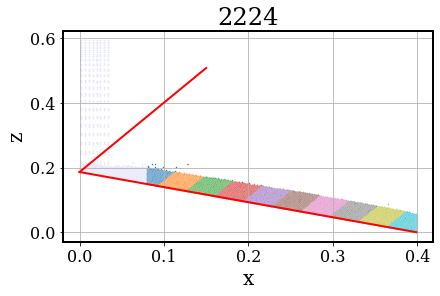

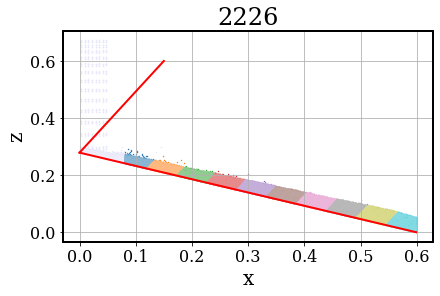

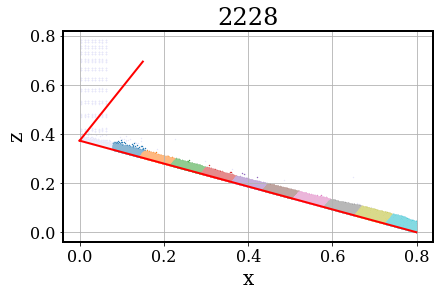

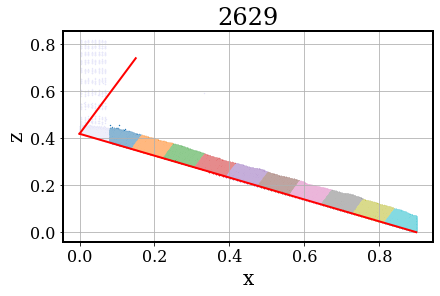

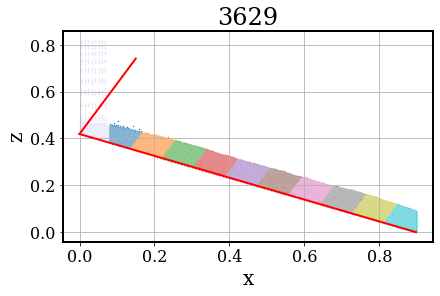

In [6]:
with open('filenames.txt') as file:
    for name in file:
        check(name.rstrip('\n'))

:) Yay! No assert statements appeared when the code was run, meaning that mathematically the slopes of $Z'$ and $X'$ are perpendicular. One thing that is noticed is that, while mathematically correct, when pictured, the slopes do not appear perpendicular. 